<a href="https://colab.research.google.com/github/ailtiakova/pythonprojects/blob/master/Cohort_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Cohort Analysis

It’s more cost effective to retain existing customers than to acquire new ones, which is why it’s important to track whether 

Sources: https://medium.com/swlh/understanding-customer-retention-rates-with-cohort-analysis-using-python-and-seaborn-5da6ea015935

Datacamp: https://campus.datacamp.com/courses/customer-segmentation-in-python/cohort-analysis?ex=3

In [1]:
# Import libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


There are multiple ways to instantiate data into Colab notebooks. Follow the tips shared in this post: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

In [0]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
df1 = pd.read_excel(url)
# Dataset is now stored in a Pandas Dataframe

In [0]:
# Convert InvoiceDate from object to datetime format
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])

In [0]:
# Create function to truncate given date in column to a first day of the month
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [9]:
# Apply function to invoice date to invoice month column
df1['InvoiceMonth'] = df1['InvoiceDate'].apply(get_month)
grouping1 = df1.groupby('CustomerID')['InvoiceMonth']
df1['CohortMonth'] = grouping1.transform('min')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     541909 non-null  object        
 1   StockCode     541909 non-null  object        
 2   Description   540455 non-null  object        
 3   Quantity      541909 non-null  int64         
 4   InvoiceDate   541909 non-null  datetime64[ns]
 5   UnitPrice     541909 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       541909 non-null  object        
 8   InvoiceMonth  541909 non-null  datetime64[ns]
 9   CohortMonth   406829 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 41.3+ MB


In [0]:
df1 = df1[df1.CustomerID.notnull()]

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     406829 non-null  object        
 1   StockCode     406829 non-null  object        
 2   Description   406829 non-null  object        
 3   Quantity      406829 non-null  int64         
 4   InvoiceDate   406829 non-null  datetime64[ns]
 5   UnitPrice     406829 non-null  float64       
 6   CustomerID    406829 non-null  float64       
 7   Country       406829 non-null  object        
 8   InvoiceMonth  406829 non-null  datetime64[ns]
 9   CohortMonth   406829 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(1), object(4)
memory usage: 34.1+ MB


In [0]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
invoice_year, invoice_month, _ = get_date_int(df1, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(df1, 'CohortMonth')

In [0]:
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

In [16]:
df1['CohortIndex'] = years_diff * 12 + months_diff + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [18]:
# Count monthly active customers from each cohort
grouping_count = df1.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')
cohort_counts.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN


In [0]:
# --Calculate Retention Rate--
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3) * 100
retention.index = retention.index.strftime('%m-%Y')

In [0]:
# --Calculate Average Quantity--
grouping_qty = df1.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_qty = grouping_qty['Quantity'].mean()
cohort_data_qty = cohort_data_qty.reset_index()
average_quantity = cohort_data_qty.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='Quantity')
average_quantity.index = average_quantity.index.strftime('%m-%Y')

In [0]:
# --Calculate Average Price--
grouping_price = df1.groupby(['CohortMonth', 'CohortIndex'])
cohort_data_price = grouping_price['UnitPrice'].mean()
cohort_data_price = cohort_data_price.reset_index()
average_price = cohort_data_price.pivot(index='CohortMonth',
                                     columns='CohortIndex',
                                     values='UnitPrice')
average_price.index = average_price.index.strftime('%m-%Y')

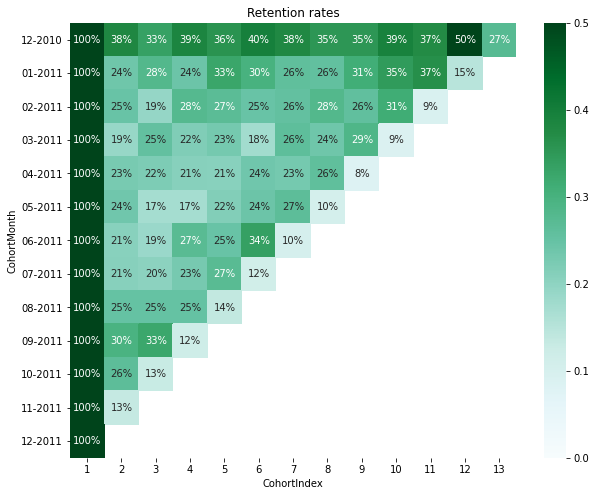

In [26]:
# --Plot heatmap using seaborn--
# Plot retention rates
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention, annot = True, fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap = 'BuGn')
plt.show()

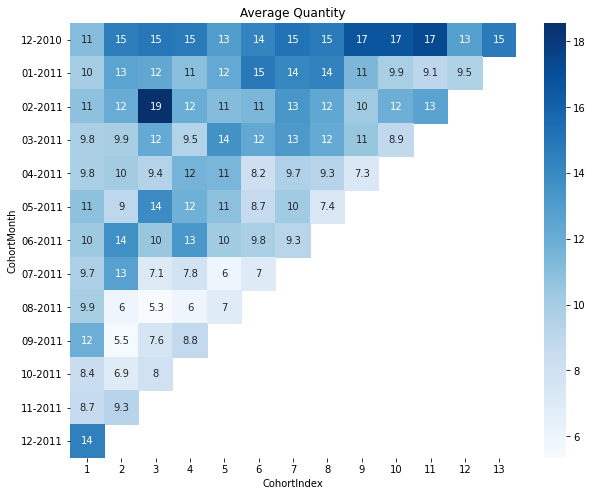

In [27]:
# Plot average quantity
plt.figure(figsize=(10, 8))
plt.title('Average Quantity')
sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
plt.show()

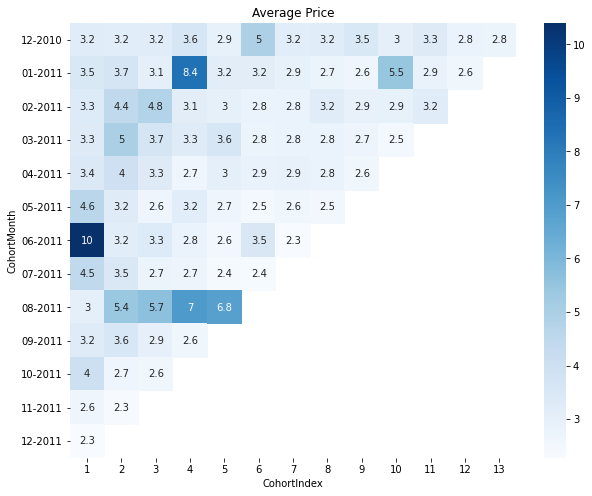

In [28]:
# Plot average price
plt.figure(figsize=(10, 8))
plt.title('Average Price')
sns.heatmap(data = average_price, annot=True, cmap='Blues')
plt.show()